<a href="https://colab.research.google.com/github/pythonuzgit/elmurodov/blob/master/Deep%20learning%20with%20PyTorch/Guadalajara_rent_prices_prediction_Tensorflow_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.datasets.utils import download_url
import torch.optim as optim
from pandas import DataFrame

In [ ]:
data = pd.read_csv('/content/data_updated.csv')
data.head()

,Unnamed: 0,location,price,bedrooms,bathrooms,garage,area
0,0,Zapopan,22300,3,4,2,180
1,1,Real Vallarta,12500,2,2,2,100
2,2,Puertas del Tule,25000,4,4,2,187
3,3,Zapopan,58000,3,4,4,700
4,4,Heroes Nacionales,9000,3,2,2,110


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  418 non-null    int64 
 1   location    418 non-null    object
 2   price       418 non-null    int64 
 3   bedrooms    418 non-null    int64 
 4   bathrooms   418 non-null    int64 
 5   garage      418 non-null    int64 
 6   area        418 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 23.0+ KB


Preprocessing

In [ ]:
data = data.drop('Unnamed: 0', axis = 1)

In [ ]:
data.head()

,location,price,bedrooms,bathrooms,garage,area
0,Zapopan,22300,3,4,2,180
1,Real Vallarta,12500,2,2,2,100
2,Puertas del Tule,25000,4,4,2,187
3,Zapopan,58000,3,4,4,700
4,Heroes Nacionales,9000,3,2,2,110


In [ ]:
data = data.drop('location', axis = 1)

In [ ]:
data.head()

,price,bedrooms,bathrooms,garage,area
0,22300,3,4,2,180
1,12500,2,2,2,100
2,25000,4,4,2,187
3,58000,3,4,4,700
4,9000,3,2,2,110


Splitting and Scaling

In [ ]:
y = data['price'].copy()
X = data.drop('price', axis = 1).copy()

In [ ]:
y.shape, X.shape

((418,), (418, 4))

In [ ]:
scalar = StandardScaler()
X = scalar.fit_transform(X)

In [ ]:
tf_X_train, tf_X_test, tf_y_train, tf_y_test = train_test_split(X, y, train_size = 0.1, 
                                                                 random_state = 1)

Training with TensorFlow

In [ ]:
tf_X_train.shape

(41, 4)

In [ ]:
inputs = tf.keras.Input(shape = 4)
hidden = tf.keras.layers.Dense(64, activation = 'relu')(inputs)
hidden = tf.keras.layers.Dense(64, activation='relu')(hidden)
outputs = tf.keras.layers.Dense(1, activation='linear')(hidden)

tf_model = tf.keras.Model(inputs, outputs)

tf_model.compile(optimizer = 'adam', loss = 'mse')

history = tf_model.fit(
    tf_X_train,
    tf_y_train,
    validation_split = 0.12,
    batch_size = 32,
    epochs = 10
)


Epoch 1/10
2/2 [==============================] - 1s 157ms/step - loss: 1171278336.0000 - val_loss: 393501344.0000
Epoch 2/10
2/2 [==============================] - 0s 25ms/step - loss: 1171271936.0000 - val_loss: 393498816.0000
Epoch 3/10
2/2 [==============================] - 0s 28ms/step - loss: 1171266048.0000 - val_loss: 393496192.0000
Epoch 4/10
2/2 [==============================] - 0s 36ms/step - loss: 1171260288.0000 - val_loss: 393493696.0000
Epoch 5/10
2/2 [==============================] - 0s 28ms/step - loss: 1171254528.0000 - val_loss: 393491232.0000
Epoch 6/10
2/2 [==============================] - 0s 32ms/step - loss: 1171248896.0000 - val_loss: 393488896.0000
Epoch 7/10
2/2 [==============================] - 0s 28ms/step - loss: 1171243520.0000 - val_loss: 393486496.0000
Epoch 8/10
2/2 [==============================] - 0s 27ms/step - loss: 1171237504.0000 - val_loss: 393483968.0000
Epoch 9/10
2/2 [==============================] - 0s 28ms/step - loss: 1171231488.0000 

In [ ]:
tf_rmse = np.sqrt(tf_model.evaluate(tf_X_test, tf_y_test))

12/12 [==============================] - 0s 2ms/step - loss: 988453952.0000


Training with PyTorch

In [ ]:
batch_size=64
learning_rate=5e-7
input_size =4
output_size = 1

In [ ]:
dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
train_ds, val_ds = random_split(dataset, [318, 100])


train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)

len(train_loader), len(val_loader)

(5, 1)

Model

In [ ]:
class HousingModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(input_size, output_size)


  def forward(self, xb):
    out = self.linear(xb)
    return out


  def training_step(self, batch):
    X, y = batch
    out = self(X)                 
    loss = F.mse_loss(out, y)    
    return loss 


  def validation_step(self, batch):
    X, y = batch
    out = self(X)                
    loss = F.mse_loss(out, y)    
    return {'val_loss': loss.detach()}  


  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   
    return {'val_loss': epoch_loss.item()} 


  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))  




model = HousingModel()    





In [ ]:
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)

  for epoch in range(epochs):
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)

  return history    


In [ ]:
result = evaluate(model, val_loader)
result

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


{'val_loss': 1200750848.0}

In [ ]:
history = fit(10, learning_rate, model, train_loader, val_loader)

Epoch [0], val_loss: 1200744832.0000
Epoch [1], val_loss: 1200738688.0000
Epoch [2], val_loss: 1200732800.0000
Epoch [3], val_loss: 1200726656.0000
Epoch [4], val_loss: 1200720640.0000
Epoch [5], val_loss: 1200714752.0000
Epoch [6], val_loss: 1200708608.0000
Epoch [7], val_loss: 1200702592.0000
Epoch [8], val_loss: 1200696448.0000
Epoch [9], val_loss: 1200690560.0000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Using a target size (torch.Size([62])) that is different to the input size (torch.Size([62, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


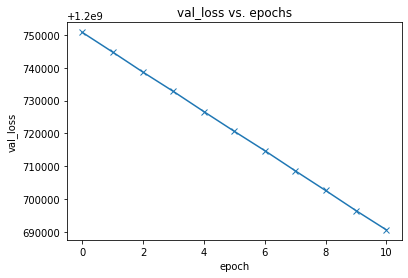

In [ ]:
losses = [r['val_loss'] for r in [result] + history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs');